In [1]:
import argparse
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim
import clip

from functools import partial

# from cross_domain_fsl.options import parse_args

# from cross_domain_fsl.methods.backbone_multiblock import model_dict
from cross_domain_fsl.methods.protonet import ProtoNet

# from cross_domain_fsl.data.datamgr import SetDataManager
from cross_domain_fsl.data.managers import MANAGER_DICT

# the finetuning is very sensitive to lr
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 224
CLIP_DIM_MAPPING = {"ViT-B/32": 512, "ViT-B/16": 512, "ViT-L/14": 768, "RN50": 1024}

## Definitions

In [2]:
class CLIP(nn.Module):
    def __init__(self, vision_model="ViT-B/32"):
        super(CLIP, self).__init__()
        model, preprocess = clip.load(vision_model, DEVICE)

        self.transform = preprocess

        # Freeze CLIP backbone
        for param in model.parameters():
            param.requires_grad = False

        self.model = model

        self.final_feat_dim = CLIP_DIM_MAPPING[vision_model]

    def forward(self, x):
        # x = self.transform(x)  # SetDataLoader yields transformed images
        # TODO: Note that clip usually normalises images
        x = self.model.encode_image(x)
        return x

In [3]:
class DummyArgs:
    def __init__(self):
        self.vision_model = "ViT-B/32"
        self.dataset = "EuroSAT"
        self.n_way = 5
        self.n_query = 15
        self.n_support = 5

args = DummyArgs()

In [4]:
from cross_domain_fsl.methods.backbone_multiblock import model_dict
model_dict

{'Conv4': <function cross_domain_fsl.methods.backbone_multiblock.Conv4()>,
 'Conv6': <function cross_domain_fsl.methods.backbone_multiblock.Conv6()>,
 'ResNet10': <function cross_domain_fsl.methods.backbone_multiblock.ResNet10(flatten=True, leakyrelu=False)>,
 'ResNet10_Multi': <function cross_domain_fsl.methods.backbone_multiblock.ResNet10_Multi(flatten=True, leakyrelu=False)>,
 'ResNet18': <function cross_domain_fsl.methods.backbone_multiblock.ResNet18(flatten=True, leakyrelu=False)>,
 'ResNet34': <function cross_domain_fsl.methods.backbone_multiblock.ResNet34(flatten=True, leakyrelu=False)>}

## Load in CLIP Backbone, DataLoader and ProtoNet

In [5]:
clip_backbone = CLIP(vision_model=args.vision_model).to(DEVICE)
transform = clip_backbone.transform

In [6]:
mgr_cls = MANAGER_DICT[args.dataset]
datamgr = mgr_cls(
    IMAGE_SIZE,
    transform,
    n_way=args.n_way,
    n_query=args.n_query,
    n_support=args.n_support,
)

test_loader = datamgr.get_data_loader(aug=False)

self.transform:  Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f1121c52bf8>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
transform:  Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f1121c52bf8>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
3000
3000
3000
2500
2500
2000
2500
3000
2500
3000


In [7]:
EuroSAT_path = "/scratch_net/biwidl309/jamliu/code/datasets/EuroSAT/2750"
from torchvision.datasets import ImageFolder

d = ImageFolder(EuroSAT_path)

sub_meta = {}

for i in range(10):
    sub_meta[i] = []

for i, (data, label) in enumerate(d):
    sub_meta[label].append(data)

<class 'PIL.Image.Image'>


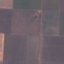

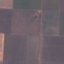

0


In [8]:
import numpy as np

original = sub_meta[0][0]
print(type(original))
original.show()
transformed = original.convert("RGB")
transformed.show()
print(np.sum(np.array(original) - np.array(transformed)))

$\Rightarrow$ a redundant RGB conversion on PIL image shouldn't cause differences

In [9]:
# default_datamgr = mgr_cls(
#     IMAGE_SIZE,
#     n_way=args.n_way,
#     n_query=args.n_query,
#     n_support=args.n_support,
# )

# default_test_loader = default_datamgr.get_data_loader(aug=False)

self.transform:  None
transform:  Compose(
    Scale(size=[257, 257], interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


/scratch_net/biwidl309/jamliu/conda_envs/style-adv/lib/python3.6/site-packages/torchvision/transforms/transforms.py:318: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


3000
3000
3000
2500
2500
2000
2500
3000
2500
3000


In [10]:
from torchvision.transforms import Scale, CenterCrop, ToTensor, Normalize, Compose

In [11]:
scale = Scale(224)
original_tensor = ToTensor()(original)
Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(original_tensor)

tensor([[[ 0.4337,  0.3994,  0.3823,  ..., -0.3712, -0.3369, -0.3541],
         [ 0.4337,  0.4337,  0.4337,  ..., -0.3712, -0.3369, -0.3541],
         [ 0.3309,  0.3481,  0.3994,  ..., -0.3712, -0.3712, -0.3541],
         ...,
         [ 0.2967,  0.2967,  0.2282,  ..., -0.3541, -0.4054, -0.3883],
         [ 0.1083,  0.1426,  0.0912,  ..., -0.3198, -0.3198, -0.2856],
         [-0.0287, -0.0287, -0.0629,  ..., -0.3027, -0.3027, -0.2856]],

        [[ 0.0826,  0.0826,  0.0651,  ..., -0.4601, -0.4251, -0.4426],
         [ 0.0826,  0.0826,  0.0476,  ..., -0.4601, -0.4251, -0.4426],
         [ 0.0126, -0.0224, -0.0049,  ..., -0.4251, -0.4601, -0.4426],
         ...,
         [ 0.0126,  0.0126,  0.0126,  ..., -0.4076, -0.4601, -0.4601],
         [-0.0924, -0.0749, -0.1099,  ..., -0.3901, -0.4076, -0.3725],
         [-0.1800, -0.1975, -0.2325,  ..., -0.3725, -0.3725, -0.3725]],

        [[ 0.2871,  0.2871,  0.2696,  ..., -0.0615, -0.0267, -0.0441],
         [ 0.2871,  0.2871,  0.2696,  ..., -0

In [40]:
# model_func = model_dict["ResNet10"]
def model_func(**kwargs):
    return clip_backbone
protonet = ProtoNet(
    model_func, n_way=args.n_way, n_support=args.n_support, tf_path=None
).to(DEVICE)

## Take one batch and visualise

In [13]:
x, y = next(iter(test_loader))
print(x.size(), y.size())
print(y)

torch.Size([5, 20, 3, 224, 224]) torch.Size([5, 20])
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]])


### Visualise support & query sets

- Using the **CLIP** normalisation / `transform`

In [14]:
x_support = x[:, :args.n_support]
print(x_support.size())

x_query = x[:, args.n_support:]
print(x_query.size())

torch.Size([5, 5, 3, 224, 224])
torch.Size([5, 15, 3, 224, 224])


Text(0, 0.5, 'Density')

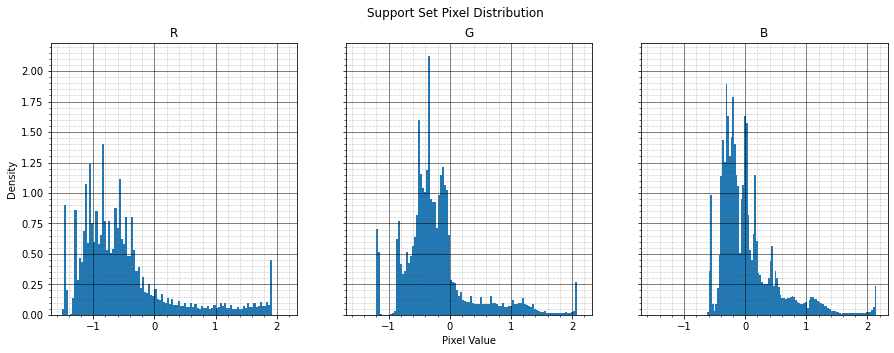

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, sharex="all", sharey="all", figsize=(15, 5))
channels = ["R", "G", "B"]
for i in range(3):
    _ = axs[i].hist(x_support[:, :, i, :, :].flatten().cpu().numpy(), bins=100, density=True)
    axs[i].minorticks_on()
    axs[i].set_title(f"{channels[i]}")
    axs[i].grid(which='major', linestyle='-', linewidth='0.5', color='black')  # Major grid lines
    axs[i].grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

fig.suptitle("Support Set Pixel Distribution")
axs[1].set_xlabel("Pixel Value")
axs[0].set_ylabel("Density")

In [16]:
from matplotlib.colors import Normalize
vmin = x_support.min()
vmax = x_support.max()

norm = Normalize(vmin=vmin, vmax=vmax)
norm

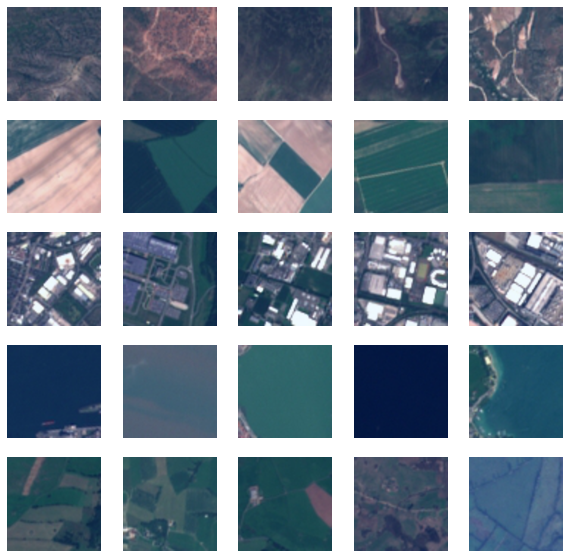

classes: tensor([2, 0, 4, 9, 5])


In [22]:
# Plot the support set

fig, axs = plt.subplots(args.n_way, args.n_support, figsize=(10, 10))
for i in range(args.n_way):
    for j in range(args.n_support):
        _ = axs[i, j].imshow(norm(x_support[i, j].permute(1, 2, 0)))
        _ = axs[i, j].axis("off")
    _ = axs[i, 0].set_ylabel(f"Class {i}")
plt.show()
print(f"classes: {y[:, 0]}")

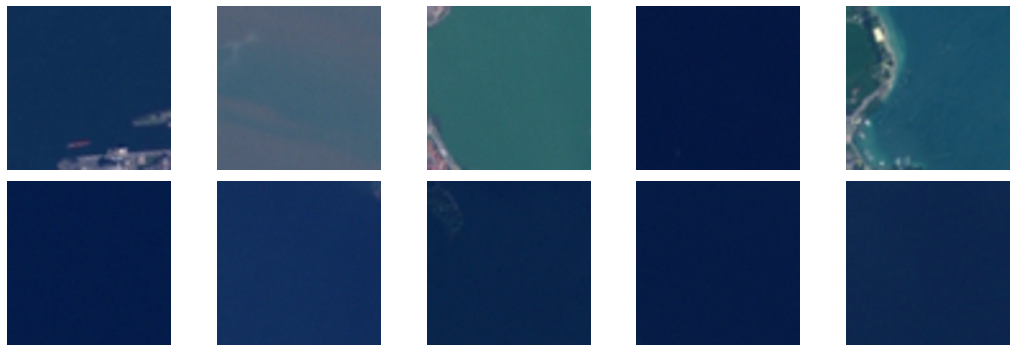

In [26]:
fig, axs = plt.subplots(2, args.n_support, figsize=(15, 5))
# class 9 in EuroSAT seems to have difficult images: Sea lake
i = 3  

# All queries for class 9
for j in range(args.n_support):
    _ = axs[0, j].imshow(norm(x_support[i, j].permute(1, 2, 0)))
    _ = axs[0, j].axis("off")

# First 5 support images for class 9
for j in range(args.n_support):
    _ = axs[1, j].imshow(norm(x_query[i, j].permute(1, 2, 0)))
    _ = axs[1, j].axis("off")

plt.tight_layout()

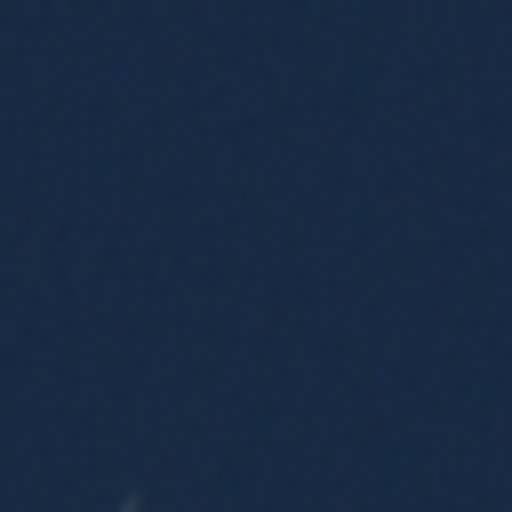

In [33]:
sub_meta[9][0].resize([512, 512]).show()  # Sea Lake image

## Run Inference with CLIP-ProtoNet

In [66]:
y_query = y[:, args.n_support:].contiguous().view(-1).to(DEVICE)
print(y_query.shape)

IS_FEATURE = True

scores = protonet.set_forward(x, IS_FEATURE)
print(f"scores shape: {scores.shape}")

preds = nn.functional.softmax(scores, dim=1).argmax(1)
acc = torch.sum(preds == y_query) / len(y_query)
print(f"Batch accuracy: {acc.item()}")

torch.Size([75])
scores shape: torch.Size([75, 5])
Batch accuracy: 0.02666666731238365


In [78]:
classes = y[:, 0].to(DEVICE)
print("classes: ", classes)
y_q = y_query.view(args.n_way, args.n_query).to(DEVICE)
print(y_q)
preds_q = preds.view(args.n_way, args.n_query).to(DEVICE)
print(preds_q)

# # Map the argmax predictions to the original class labels
preds_mapped = classes[preds_q]

print(preds_mapped)

print(f"Accuracy: {torch.sum(preds_mapped == y_q) / len(y_query)}")

classes:  tensor([2, 0, 4, 9, 5], device='cuda:0')
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
        [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]], device='cuda:0')
tensor([[4, 0, 1, 3, 3, 0, 1, 1, 3, 3, 1, 2, 1, 3, 1],
        [1, 1, 1, 1, 2, 2, 3, 1, 2, 1, 1, 1, 1, 1, 0],
        [2, 2, 1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 2, 1, 2],
        [3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3],
        [4, 1, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 1, 3]], device='cuda:0')
tensor([[5, 2, 0, 9, 9, 2, 0, 0, 9, 9, 0, 4, 0, 9, 0],
        [0, 0, 0, 0, 4, 4, 9, 0, 4, 0, 0, 0, 0, 0, 2],
        [4, 4, 0, 4, 0, 0, 0, 0, 2, 4, 0, 0, 4, 0, 4],
        [9, 9, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 0, 9, 9],
        [5, 0, 9, 9, 5, 9, 9, 9, 9, 9, 9, 9, 5, 0, 9]], device='cuda:0')
Accuracy: 0.4533333480358124
